In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb

In [2]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
PATHDATASET = '../dataset/'

In [7]:

print('Importing data...')
data = pd.read_csv(PATHDATASET+'application_train.csv')
test = pd.read_csv(PATHDATASET+'application_test.csv')
prev = pd.read_csv(PATHDATASET+'previous_application.csv')
buro = pd.read_csv(PATHDATASET+'bureau.csv')
buro_balance = pd.read_csv(PATHDATASET+'bureau_balance.csv')
credit_card  = pd.read_csv(PATHDATASET+'credit_card_balance.csv')
POS_CASH  = pd.read_csv(PATHDATASET+'POS_CASH_balance.csv')
payments = pd.read_csv(PATHDATASET+'installments_payments.csv')
lgbm_submission = pd.read_csv(PATHDATASET+'sample_submission.csv')

#Separate target variable
y = data['TARGET']
del data['TARGET']

Importing data...


In [13]:
#Feature engineering
#data['loan_to_income'] = data.AMT_ANNUITY/data.AMT_INCOME_TOTAL
#test['loan_to_income'] = test.AMT_ANNUITY/test.AMT_INCOME_TOTAL

#One-hot encoding of categorical features in data and test sets
categorical_features = [col for col in data.columns if data[col].dtype == 'object']

one_hot_df = pd.concat([data,test])
one_hot_df = pd.get_dummies(one_hot_df, columns=categorical_features)

data = one_hot_df.iloc[:data.shape[0],:]
test = one_hot_df.iloc[data.shape[0]:,]


In [7]:
# print(data.dtypes)

In [27]:

#Pre-processing buro_balance
print('Pre-processing buro_balance...')
buro_grouped_size = buro_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].size()
buro_grouped_max = buro_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].max()
buro_grouped_min = buro_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].min()

buro_counts = buro_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts(normalize = False)
buro_counts_unstacked = buro_counts.unstack('STATUS')
buro_counts_unstacked.columns = ['STATUS_0', 'STATUS_1','STATUS_2','STATUS_3','STATUS_4','STATUS_5','STATUS_C','STATUS_X',]
buro_counts_unstacked['MONTHS_COUNT'] = buro_grouped_size
buro_counts_unstacked['MONTHS_MIN'] = buro_grouped_min
buro_counts_unstacked['MONTHS_MAX'] = buro_grouped_max

buro = buro.join(buro_counts_unstacked, how='left', on='SK_ID_BUREAU')

Pre-processing buro_balance...


ValueError: columns overlap but no suffix specified: Index(['STATUS_0', 'STATUS_1', 'STATUS_2', 'STATUS_3', 'STATUS_4', 'STATUS_5',
       'STATUS_C', 'STATUS_X', 'MONTHS_COUNT', 'MONTHS_MIN', 'MONTHS_MAX'],
      dtype='object')

In [14]:
# buro_balance['AMT_CREDIT_SUM_DEBT'].value_counts

In [15]:
# ERR NÃO MELHOROU

#Pre-processing buro_balance
# print('Pre-processing buro_balance...')
# buro['PCT_CREDIT_SUM_DEBT(ENG)'] = buro['AMT_CREDIT_SUM_DEBT']/buro['AMT_CREDIT_SUM']
buro['PCT_CREDIT_SUM_DEBT_LIMIT(ENG)'] = buro['AMT_CREDIT_SUM_DEBT']/buro['AMT_CREDIT_SUM_LIMIT']
buro['PCT_CREDIT_SUM_OVERDUE(ENG)'] = buro['AMT_CREDIT_SUM_OVERDUE']/buro['AMT_CREDIT_SUM']
buro['PCT_CREDIT_SUM_OVERDUE_LIMIT(ENG)'] = buro['AMT_CREDIT_SUM_OVERDUE']/buro['AMT_CREDIT_SUM_LIMIT']
buro['PCT_CREDIT_MAX_OVERDUE(ENG)'] = buro['AMT_CREDIT_MAX_OVERDUE']/buro['AMT_CREDIT_SUM']
buro['PCT_CREDIT_MAX_OVERDUE_LIMIT(ENG)'] = buro['AMT_CREDIT_MAX_OVERDUE']/buro['AMT_CREDIT_SUM_LIMIT']
buro['PCT_ANNUITY(ENG)'] = buro['AMT_ANNUITY']/buro['AMT_CREDIT_SUM']
buro['AMT_CREDIT_SUM_PER_REMAINING_DAY(ENG)'] = buro['AMT_CREDIT_SUM']/buro['DAYS_CREDIT_ENDDATE']
buro['AMT_CREDIT_SUM_DEBT_PER_REMAINING_DAY(ENG)'] = buro['AMT_CREDIT_SUM_DEBT']/buro['DAYS_CREDIT_ENDDATE']
buro['AMT_CREDIT_SUM_OVERDUE_PER_REMAINING_DAY(ENG)'] = buro['AMT_CREDIT_SUM_OVERDUE']/buro['DAYS_CREDIT_ENDDATE']


In [17]:
#Pre-processing previous_application
print('Pre-processing previous_application...')
#One-hot encoding of categorical features in previous application data set
prev_cat_features = [pcol for pcol in prev.columns if prev[pcol].dtype == 'object']
prev = pd.get_dummies(prev, columns=prev_cat_features)

prev['PCT_ANNUITY(ENG)'] = prev['AMT_ANNUITY']/prev['AMT_CREDIT']
prev['PCT_APPROVED_APPLICATION(ENG)'] = prev['AMT_CREDIT']/prev['AMT_APPLICATION']
prev['PCT_DOWN_PAYMENT(ENG)'] = prev['AMT_DOWN_PAYMENT']/prev['AMT_CREDIT']
prev['PCT_GOODS_PRICE_APPLICATION(ENG)'] = prev['AMT_GOODS_PRICE']/prev['AMT_APPLICATION']
prev['PCT_GOODS_PRICE_CREDIT(ENG)'] = prev['AMT_GOODS_PRICE']/prev['AMT_CREDIT']
prev['AMT_CREDIT_PER_MONTH(ENG)'] = prev['AMT_CREDIT']/prev['CNT_PAYMENT']
    
avg_prev = prev.groupby('SK_ID_CURR').mean()
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
avg_prev['nb_app'] = cnt_prev['SK_ID_PREV']
del avg_prev['SK_ID_PREV']

Pre-processing previous_application...


In [18]:
#Pre-processing buro
print('Pre-processing buro...')
#One-hot encoding of categorical features in buro data set
buro_cat_features = [bcol for bcol in buro.columns if buro[bcol].dtype == 'object']
buro = pd.get_dummies(buro, columns=buro_cat_features)
avg_buro = buro.groupby('SK_ID_CURR').mean()
avg_buro['buro_count'] = buro[['SK_ID_BUREAU', 'SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
del avg_buro['SK_ID_BUREAU']




Pre-processing buro...


In [19]:
#Pre-processing POS_CASH
print('Pre-processing POS_CASH...')
le = LabelEncoder()
POS_CASH['NAME_CONTRACT_STATUS'] = le.fit_transform(POS_CASH['NAME_CONTRACT_STATUS'].astype(str))
nunique_status = POS_CASH[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status2 = POS_CASH[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()

POS_CASH['PCT_INSTALMENT_FUTURE(ENG)'] = POS_CASH['CNT_INSTALMENT_FUTURE']/POS_CASH['CNT_INSTALMENT']
POS_CASH['PCT_SK_DPD_DEF(ENG)'] = POS_CASH['SK_DPD_DEF']/POS_CASH['SK_DPD']
    
POS_CASH['NUNIQUE_STATUS'] = nunique_status['NAME_CONTRACT_STATUS']
POS_CASH['NUNIQUE_STATUS2'] = nunique_status2['NAME_CONTRACT_STATUS']
POS_CASH.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

Pre-processing POS_CASH...


In [20]:
#Pre-processing credit_card
print('Pre-processing credit_card...')
credit_card['NAME_CONTRACT_STATUS'] = le.fit_transform(credit_card['NAME_CONTRACT_STATUS'].astype(str))
nunique_status = credit_card[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status2 = credit_card[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()

for feature in ['DRAWINGS_ATM_CURRENT', 'DRAWINGS_CURRENT', 'DRAWINGS_OTHER_CURRENT', 'DRAWINGS_POS_CURRENT']:
    credit_card['PCT_'+feature+'(ENG)'] = credit_card['AMT_'+feature]/credit_card['AMT_CREDIT_LIMIT_ACTUAL']
    credit_card['PCT_'+feature+'_PER_DRAWING(ENG)'] = credit_card['PCT_'+feature+'(ENG)']/credit_card['CNT_'+feature]
    credit_card['PCT_BALANCE(ENG)'] = credit_card['AMT_BALANCE']/credit_card['AMT_CREDIT_LIMIT_ACTUAL']
    credit_card['TAX_RATE(ENG)'] = credit_card['AMT_BALANCE']/credit_card['AMT_RECEIVABLE_PRINCIPAL']
    credit_card['PCT_PAYMENT_CURRENT(ENG)'] = credit_card['AMT_PAYMENT_CURRENT']/credit_card['AMT_BALANCE']
    credit_card['PCT_PAYMENT_TOTAL_CURRENT(ENG)'] = credit_card['AMT_PAYMENT_TOTAL_CURRENT']/credit_card['AMT_BALANCE']
    
credit_card['NUNIQUE_STATUS'] = nunique_status['NAME_CONTRACT_STATUS']
credit_card['NUNIQUE_STATUS2'] = nunique_status2['NAME_CONTRACT_STATUS']
credit_card.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)


Pre-processing credit_card...


In [21]:
#Pre-processing payments
payments['PAYMENT_DELAY(ENG)'] = payments['DAYS_ENTRY_PAYMENT'] - payments['DAYS_INSTALMENT']
payments['PCT_PAYMENT(ENG)'] = payments['AMT_PAYMENT']/payments['AMT_INSTALMENT']
    
print('Pre-processing payments...')
avg_payments = payments.groupby('SK_ID_CURR').mean()
avg_payments2 = payments.groupby('SK_ID_CURR').max()
avg_payments3 = payments.groupby('SK_ID_CURR').min()
del avg_payments['SK_ID_PREV']


Pre-processing payments...


In [22]:
#Join data bases
print('Joining databases...')
data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(POS_CASH.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(POS_CASH.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(credit_card.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(credit_card.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_payments.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_payments.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_payments2.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_payments2.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_payments3.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_payments3.reset_index(), how='left', on='SK_ID_CURR')


Joining databases...


In [23]:
#Remove features with many missing values
print('Removing features with more than 80% missing...')
test = test[test.columns[data.isnull().mean() < 0.85]]
data = data[data.columns[data.isnull().mean() < 0.85]]

Removing features with more than 80% missing...


In [18]:
print(test.shape)
print(data.shape)


(48744, 495)
(307511, 495)


In [37]:
print(test.shape)
print(data.shape)
print(dat.shape)
print(dat2.shape)


(48744, 529)
(307511, 529)
(31, 529)
(13, 529)


In [36]:
# data4 = data.fillna((data.var()))
# test4 = test.fillna((test.var()))
dat = data.dropna()
dat2 = test.dropna()


In [33]:
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [35]:
# Standardize features by removing the mean and scaling to unit variance
x = StandardScaler().fit_transform(dat.values)
# perform factor analysis
FA = FactorAnalysis(n_components = 4).fit(x)

# Standardize features by removing the mean and scaling to unit variance
x2 = StandardScaler().fit_transform(dat2.values)
# perform factor analysis
FA2 = FactorAnalysis(n_components = 4).fit(x2)

In [19]:
# data4['latent_1'] = FA.transform(data4.values).T[0]
# data4['latent_2'] = FA.transform(data4.values).T[1]
# data4['latent_3'] = FA.transform(data4.values).T[2]
# data4['latent_4'] = FA.transform(data4.values).T[3]

In [21]:
#Create train and validation set
train_x, valid_x, train_y, valid_y = train_test_split(data, y, test_size=0.2, shuffle=True)

In [22]:
#------------------------Build LightGBM Model-----------------------
train_data=lgb.Dataset(train_x,label=train_y)
valid_data=lgb.Dataset(valid_x,label=valid_y)

In [34]:
#------------------------Build XGBoosting Model-----------------------
train_data2 = xgb.DMatrix(train_x,label=train_y)
valid_data2 = xgb.DMatrix(valid_x,label=valid_y)

In [31]:
import xgboost as xgb
# xgb_params = {
#     'eta': 0.05,
#     'max_depth': 5,
#     'subsample': 0.7,
#     'colsample_bytree': 0.7,
#     'objective': 'reg:linear',
#     'eval_metric': 'auc',
#     'silent': 1
# }
 # https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
xgb_params = {
        'eta': 0.2,
        'colsample_bytree': 0.7,
        'colsample_bylevel':0.7,
        'min_child_weight':0,
        'alpha': 2,
        'max_depth': 5, #int(round(np.log(n_selected_features))),
      #  'scale_pos_weight': unbalance_factor/2,
        'eval_metric': 'auc',
      #  'random_state': int(time()),
        'silent': True,
        'grow_policy': 'lossguide',
        'tree_method': 'exact',
        'predictor': 'cpu_predictor',
        'objective': 'binary:logistic'
}

In [37]:
num_boost_round = 400
xgbm = xgb.train(dict(xgb_params, silent=0), train_data2, num_boost_round=num_boost_round)


In [ ]:
predictions_xgbm_prob = xgbm.predict(test)

In [ ]:
xgbm_submission.TARGET = predictions_xgbm_prob


In [ ]:
xgbm_submission.to_csv('lgbm_submission1xgbm.csv', index=False)


In [ ]:

#Plot Variable Importances
#lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')

In [24]:
#Select Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : 10,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
         }

In [24]:
#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 40,
                 verbose_eval= 10
                 )


Training until validation scores don't improve for 40 rounds.
[10]	valid_0's auc: 0.721306
[20]	valid_0's auc: 0.730054
[30]	valid_0's auc: 0.736397
[40]	valid_0's auc: 0.741327
[50]	valid_0's auc: 0.748153
[60]	valid_0's auc: 0.753407
[70]	valid_0's auc: 0.758233
[80]	valid_0's auc: 0.762705
[90]	valid_0's auc: 0.766303
[100]	valid_0's auc: 0.769102
[110]	valid_0's auc: 0.771797
[120]	valid_0's auc: 0.774207
[130]	valid_0's auc: 0.775765
[140]	valid_0's auc: 0.777127
[150]	valid_0's auc: 0.778358
[160]	valid_0's auc: 0.779159
[170]	valid_0's auc: 0.779848
[180]	valid_0's auc: 0.780433
[190]	valid_0's auc: 0.781097
[200]	valid_0's auc: 0.781566
[210]	valid_0's auc: 0.782008
[220]	valid_0's auc: 0.782576
[230]	valid_0's auc: 0.782887
[240]	valid_0's auc: 0.783234
[250]	valid_0's auc: 0.783492
[260]	valid_0's auc: 0.78377
[270]	valid_0's auc: 0.784058
[280]	valid_0's auc: 0.784281
[290]	valid_0's auc: 0.784463
[300]	valid_0's auc: 0.784693
[310]	valid_0's auc: 0.784834
[320]	valid_0's au

In [25]:
# Early stopping, best iteration is:
# [457Early stopping, best iteration is:  Seu envio marcou 0.764 , o que não é uma melhoria da sua melhor pontuação. Continue tentando!

# [457]	valid_0's auc: 0.785465]	valid_0's auc: 0.785465
# Early stopping, best iteration is:
# [515]	valid_0's auc: 0.784695   : Your submission scored 0.78, which is not an improvement of your best score. Keep trying!

# Early stopping, best iteration is:
# [421]	valid_0's auc: 0.787036  : Your submission scored 0.776, which is not an improvement of your best score. Keep trying!

# [420]	valid_0's auc: 0.781549
# Early stopping, best iteration is:
# [383]	valid_0's auc: 0.781555
#Predict on test set and write to submit
predictions_lgbm_prob = lgbm.predict(test)


In [26]:

lgbm_submission.TARGET = predictions_lgbm_prob


In [27]:

lgbm_submission.to_csv('lgbm_submission3.csv', index=False)

#Plot Variable Importances
#lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')

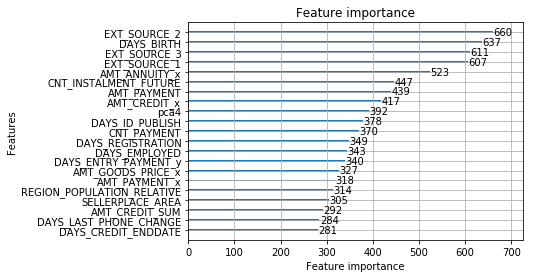

In [48]:
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')

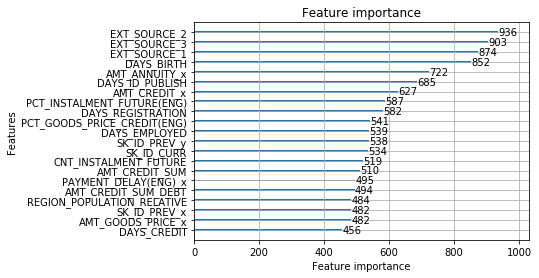

In [54]:
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')

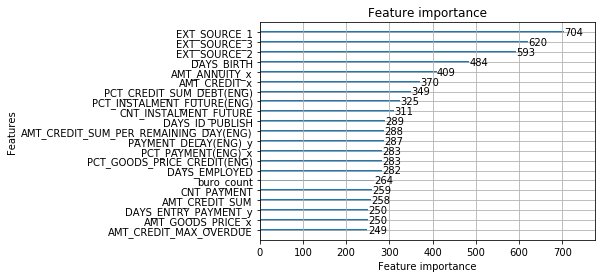

In [28]:
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')

In [25]:
from lightgbm import LGBMClassifier
import gc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
gc.enable()

In [26]:


folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds = np.zeros(data.shape[0])
sub_preds = np.zeros(test.shape[0])
feats = [f for f in data.columns if f not in ['SK_ID_CURR']]

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data)):
    trn_x, trn_y = data[feats].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = data[feats].iloc[val_idx], y.iloc[val_idx]
    
    clf = LGBMClassifier(
        # n_estimators=1000,
        # num_leaves=20,
        # colsample_bytree=.8,
        # subsample=.8,
        # max_depth=7,
        # reg_alpha=.1,
        # reg_lambda=.1,
        # min_split_gain=.01
        n_estimators=1000, #4000
        learning_rate=0.03,
        num_leaves=30,
        colsample_bytree=.8,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
    )
    
    clf.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric='auc', verbose=100, early_stopping_rounds=100  #30
           )
    
    oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
    del clf, trn_x, trn_y, val_x, val_y
    gc.collect()
    
print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 

test['TARGET'] = sub_preds

test[['SK_ID_CURR', 'TARGET']].to_csv('first_submission.csv', index=False)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.7672	valid_1's auc: 0.750744
[200]	training's auc: 0.796079	valid_1's auc: 0.772248
[300]	training's auc: 0.813255	valid_1's auc: 0.779889
[400]	training's auc: 0.826894	valid_1's auc: 0.783122
[500]	training's auc: 0.838554	valid_1's auc: 0.784472
[600]	training's auc: 0.849545	valid_1's auc: 0.785147
[700]	training's auc: 0.859007	valid_1's auc: 0.785375
[800]	training's auc: 0.867845	valid_1's auc: 0.785826
[900]	training's auc: 0.876368	valid_1's auc: 0.785922
[1000]	training's auc: 0.883961	valid_1's auc: 0.786302
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.883961	valid_1's auc: 0.786302
Fold  1 AUC : 0.786286
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.766594	valid_1's auc: 0.754843
[200]	training's auc: 0.796382	valid_1's auc: 0.772887
[300]	training's auc: 0.813965	valid_1's auc: 0.779685
[400]	training's auc: 0.827362	va